## Zooniverse Analysis

In [39]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
import seaborn as sns
from lsst.ap.association import UnpackApdbFlags, MapDiaSourceConfig
from IPython.display import Image, display, HTML


In [2]:
sns.set_context('poster')

In [3]:
dfzoo = pd.read_csv('alert-production-zoo-classifications.csv')

In [4]:
len(dfzoo)

851

In [5]:
dfzoo.head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
0,207552876,ebellm,1649740.0,2b5f117ee65c2410edb9,13338,Scan cutouts,14.25,2020-03-07 01:13:05 UTC,NaN,NaN,"{""source"":""api"",""session"":""ef4df560cf0cb8504df...","[{""task"":""T0"",""task_label"":""How would you desc...","{""40938231"":{""retired"":null,""diaSourceId"":1764...",40938231
1,207552908,ebellm,1649740.0,2b5f117ee65c2410edb9,13338,Scan cutouts,14.25,2020-03-07 01:13:13 UTC,NaN,NaN,"{""source"":""api"",""session"":""ef4df560cf0cb8504df...","[{""task"":""T0"",""task_label"":""How would you desc...","{""40938233"":{""retired"":null,""diaSourceId"":1764...",40938233
2,207553020,ebellm,1649740.0,2b5f117ee65c2410edb9,13338,Scan cutouts,14.25,2020-03-07 01:13:44 UTC,NaN,NaN,"{""source"":""api"",""session"":""ef4df560cf0cb8504df...","[{""task"":""T0"",""task_label"":""How would you desc...","{""40938229"":{""retired"":null,""diaSourceId"":1764...",40938229
3,207553077,ebellm,1649740.0,2b5f117ee65c2410edb9,13338,Scan cutouts,14.25,2020-03-07 01:14:00 UTC,NaN,NaN,"{""source"":""api"",""session"":""ef4df560cf0cb8504df...","[{""task"":""T0"",""task_label"":""How would you desc...","{""40938219"":{""retired"":null,""diaSourceId"":1764...",40938219
4,207553107,ebellm,1649740.0,2b5f117ee65c2410edb9,13338,Scan cutouts,14.25,2020-03-07 01:14:09 UTC,NaN,NaN,"{""source"":""api"",""session"":""ef4df560cf0cb8504df...","[{""task"":""T0"",""task_label"":""How would you desc...","{""40938221"":{""retired"":null,""diaSourceId"":1764...",40938221


In [6]:
#TODO: figure out how multiple classificaitons are handled!

In [7]:
def get_classification(df):
    return dfzoo['annotations'].apply(json.loads).apply(lambda x: x[0]['value'])

def get_text_comment(df):
    return dfzoo['annotations'].apply(json.loads).apply(lambda x: x[1]['value'] if (x[0]['value'] == 'Other') else None)

def get_diaSourceId(df):
    return dfzoo['subject_data'].apply(json.loads).apply(lambda x: list(x.values())[0]['diaSourceId'])

In [8]:
dfzoo['classification'] = get_classification(dfzoo)
dfzoo['comment'] = get_text_comment(dfzoo)
dfzoo['diaSourceId'] = get_diaSourceId(dfzoo)

Foolishly we mixed HSC and DECam data, and for some reason it doesn't seem like the subject sets are made distinct.  I think I should have used some additional keys, not just the diaSourceID.

Thankfully there's no overlap in diaSourceId

In [9]:
dataset = 'hits'
#dataset = 'hsc-cosmos'

In [10]:
if dataset == 'hits':
    REPO = '/project/mrawls/hits2015/rerun/decorr_2020_03'
    connection = sqlite3.connect(f'{REPO}/association.db')
    diaSources = pd.read_sql_query('select * from DiaSource', connection)
elif dataset == 'hsc-cosmos':
    REPO = '/project/mrawls/cosmos/rerun/ap_pipe-g-1'
    connection = sqlite3.connect(f'{REPO}/association.db')
    diaSources = pd.read_sql_query('select * from DiaSource', connection)
#np.intersect1d(diaSources.diaSourceId.values,hscDiaSources.diaSourceId.values)

In [11]:
diaSources = pd.merge(diaSources,dfzoo[['classification','comment','diaSourceId']],on='diaSourceId',how='inner')

In [12]:
len(diaSources)

437

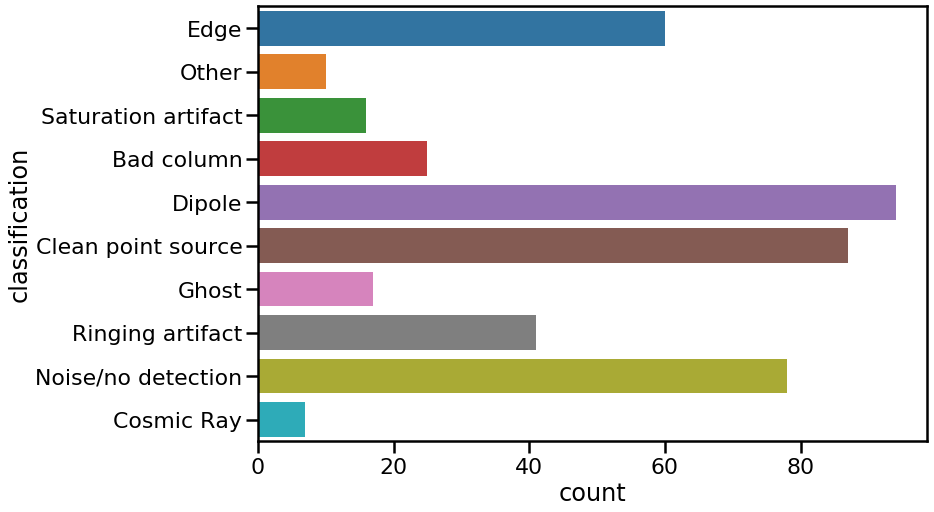

In [13]:
plt.figure(figsize=(12,8))
sns.countplot(data=diaSources,y='classification')
plt.savefig(f'fig/{dataset}/classification_summary.png', bbox_inches='tight')

In [14]:
# what about those no-detections?
wnodet = diaSources['classification'] == 'Noise/no detection'

In [15]:
diaSources.loc[wnodet,'apFlux'].head()

21      15.178801
25    1174.340475
27    1371.944239
32    1868.158490
41    2496.782781
Name: apFlux, dtype: float64

In [16]:
# via https://github.com/lsst-dm/ap_pipe-notebooks/blob/master/false_positives/False-Positive-Census.ipynb
config = MapDiaSourceConfig()
unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')
flag_values = unpacker.unpack(diaSources['flags'], 'flags')
flag_names = list(flag_values.dtype.names)
labels = ['baseFlag', 'offImage', 'edge', 'interp', 'saturated', 'CR', 'bad', 'suspect', 
          'interpCen', 'saturatedCen', 'CRCen', 'suspectCen', 
          'centroidFlag', 'centroidPosFlag', 'centroidNegFlag',
          'apFluxFlag', 'apTruncated', 'psfFluxFlag', 'noGoodPixels', 'psfFluxFlagEdge',
          'diffimForcedFlag', 'diffimForcedNoGoodPixels', 'diffimForcedEdge', 
          'shapeFlag', 'shapeUnweightedBad', 'shapeUnweighted', 'shapeShift', 'shapeMaxIter', 'shapePsf']

/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/ap_association/19.0.0-13-g744ec97+5/python/lsst/ap/association/mapApData.py:388: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  table_list = list(yaml.load_all(yaml_stream))


In [17]:
flag_names

['base_PixelFlags_flag',
 'base_PixelFlags_flag_offimage',
 'base_PixelFlags_flag_edge',
 'base_PixelFlags_flag_interpolated',
 'base_PixelFlags_flag_saturated',
 'base_PixelFlags_flag_cr',
 'base_PixelFlags_flag_bad',
 'base_PixelFlags_flag_suspect',
 'base_PixelFlags_flag_interpolatedCenter',
 'base_PixelFlags_flag_saturatedCenter',
 'base_PixelFlags_flag_crCenter',
 'base_PixelFlags_flag_suspectCenter',
 'slot_Centroid_flag',
 'slot_Centroid_pos_flag',
 'slot_Centroid_neg_flag',
 'slot_ApFlux_flag',
 'slot_ApFlux_flag_apertureTruncated',
 'slot_PsfFlux_flag',
 'slot_PsfFlux_flag_noGoodPixels',
 'slot_PsfFlux_flag_edge',
 'ip_diffim_forced_PsfFlux_flag',
 'ip_diffim_forced_PsfFlux_flag_noGoodPixels',
 'ip_diffim_forced_PsfFlux_flag_edge',
 'slot_Shape_flag',
 'slot_Shape_flag_unweightedBad',
 'slot_Shape_flag_unweighted',
 'slot_Shape_flag_shift',
 'slot_Shape_flag_maxIter',
 'slot_Shape_flag_psf']

In [18]:
flagTable = pd.DataFrame(flag_values, index=diaSources.index)
diaSources = diaSources.join(flagTable)

In [19]:
flagTable

,base_PixelFlags_flag,base_PixelFlags_flag_offimage,base_PixelFlags_flag_edge,base_PixelFlags_flag_interpolated,base_PixelFlags_flag_saturated,base_PixelFlags_flag_cr,base_PixelFlags_flag_bad,base_PixelFlags_flag_suspect,base_PixelFlags_flag_interpolatedCenter,base_PixelFlags_flag_saturatedCenter,...,slot_PsfFlux_flag_edge,ip_diffim_forced_PsfFlux_flag,ip_diffim_forced_PsfFlux_flag_noGoodPixels,ip_diffim_forced_PsfFlux_flag_edge,slot_Shape_flag,slot_Shape_flag_unweightedBad,slot_Shape_flag_unweighted,slot_Shape_flag_shift,slot_Shape_flag_maxIter,slot_Shape_flag_psf
0,False,False,False,True,False,False,True,True,False,False,...,False,False,False,False,True,True,False,False,False,False
1,False,False,True,True,True,True,True,True,True,True,...,False,False,False,False,True,True,False,False,False,False
2,False,False,True,True,True,True,False,False,True,True,...,False,False,False,False,True,False,True,False,False,False
3,False,False,False,True,False,False,True,True,True,False,...,False,False,False,False,True,True,False,False,False,False
4,False,False,True,True,True,True,True,True,True,True,...,False,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,False,False,False,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
433,False,False,False,True,False,False,True,True,True,False,...,False,False,False,False,True,True,False,False,False,False
434,False,False,True,True,True,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
435,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


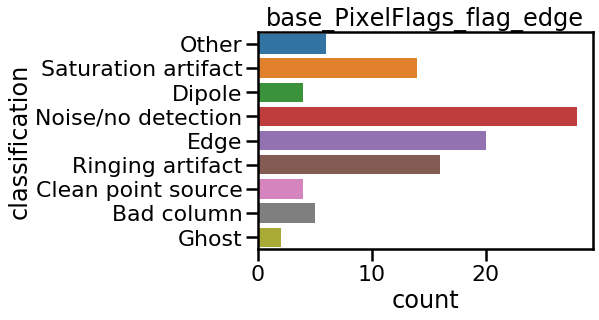

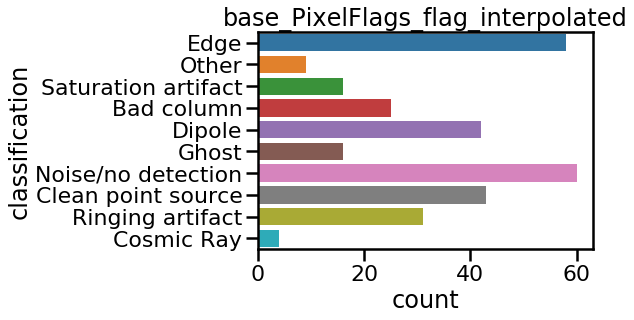

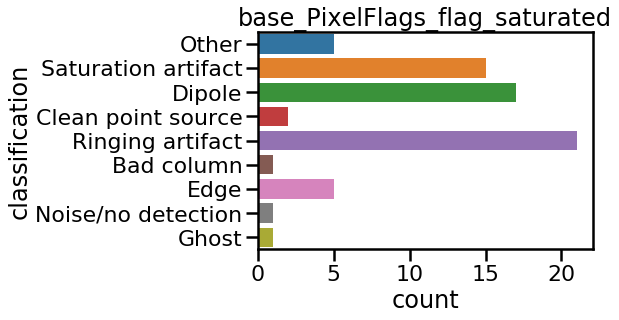

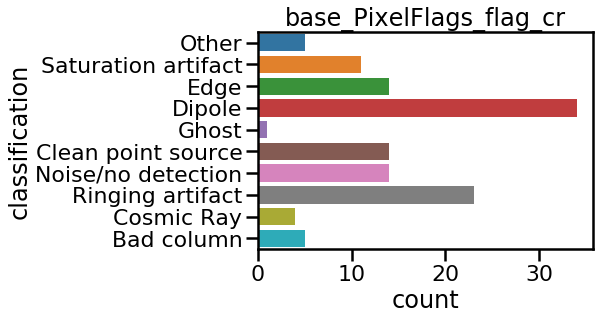

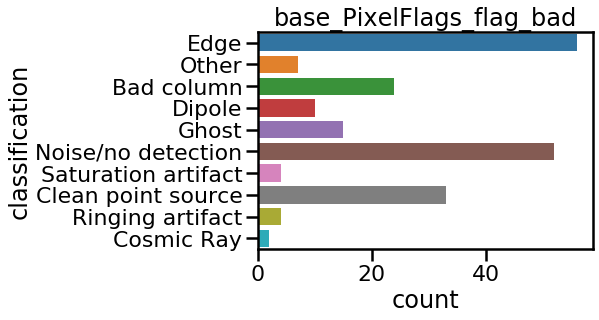

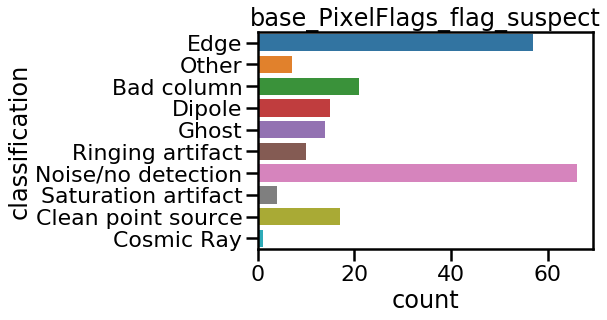

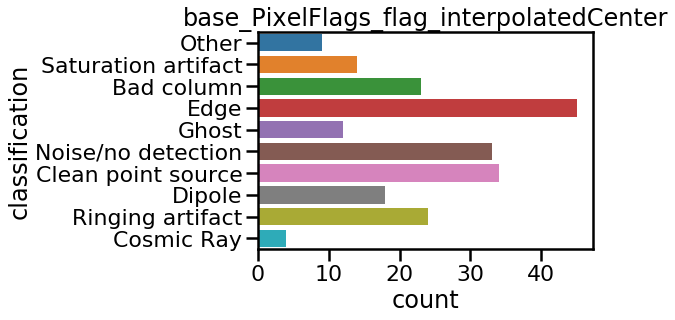

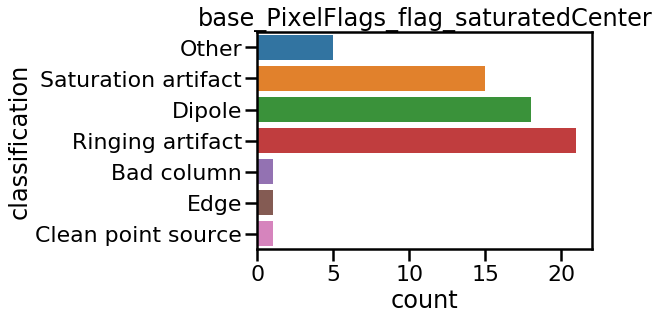

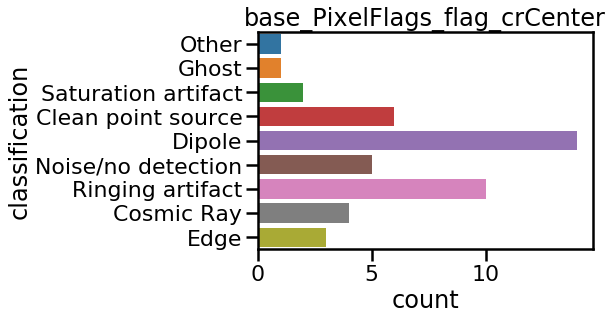

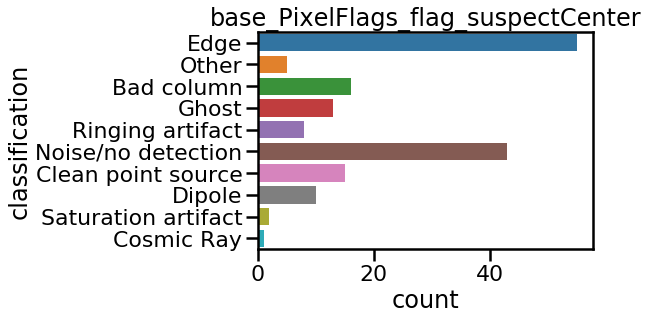

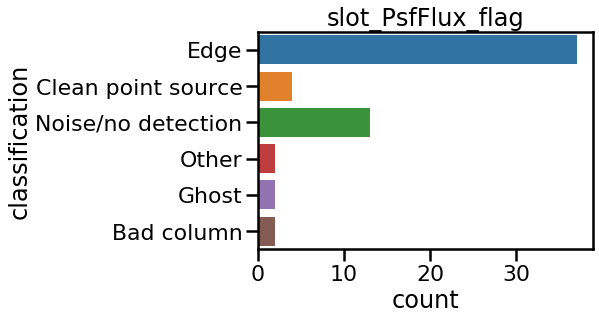

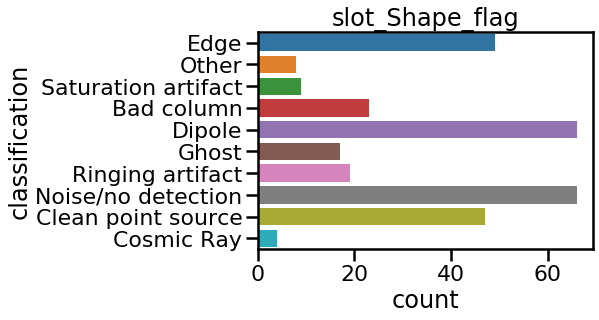

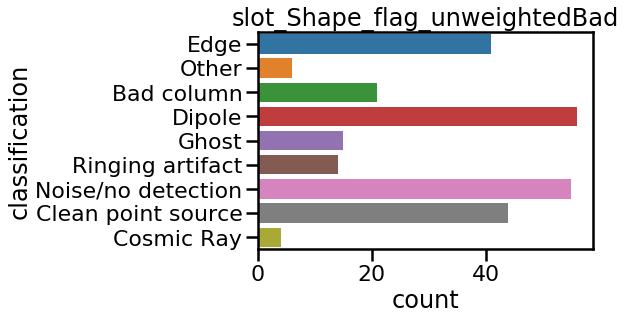

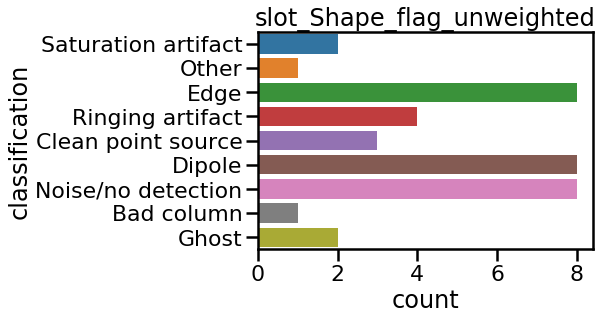

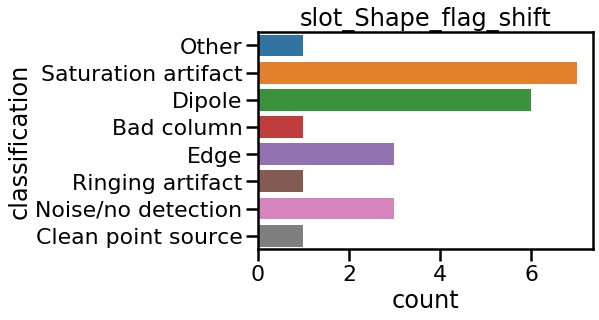

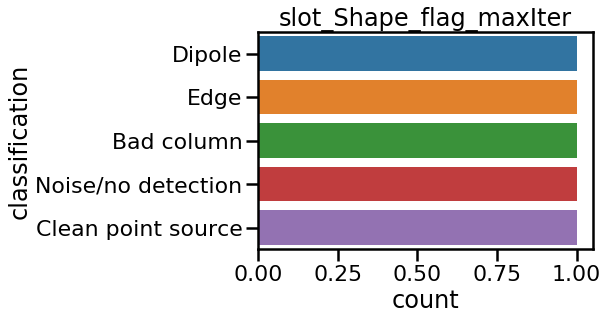

In [20]:
for name in flag_names:
    w = diaSources.loc[:,name]
    if np.sum(w):
        fig = plt.figure()
        sns.countplot(data=diaSources.loc[w,:],y='classification')
        plt.title(name)

In [21]:
classgrp = diaSources.groupby('classification')
flag_pct_byclass = classgrp[flag_names].agg(lambda x: (np.sum(x)/len(x)).astype(float))
flag_pct_byclass

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


,base_PixelFlags_flag,base_PixelFlags_flag_offimage,base_PixelFlags_flag_edge,base_PixelFlags_flag_interpolated,base_PixelFlags_flag_saturated,base_PixelFlags_flag_cr,base_PixelFlags_flag_bad,base_PixelFlags_flag_suspect,base_PixelFlags_flag_interpolatedCenter,base_PixelFlags_flag_saturatedCenter,...,slot_PsfFlux_flag_edge,ip_diffim_forced_PsfFlux_flag,ip_diffim_forced_PsfFlux_flag_noGoodPixels,ip_diffim_forced_PsfFlux_flag_edge,slot_Shape_flag,slot_Shape_flag_unweightedBad,slot_Shape_flag_unweighted,slot_Shape_flag_shift,slot_Shape_flag_maxIter,slot_Shape_flag_psf
classification,,,,,,,,,,,,,,,,,,,,,
Bad column,False,False,0.200000,1.000000,0.040000,0.200000,0.960000,0.840000,0.920000,0.040000,...,False,False,False,False,0.920000,0.840000,0.040000,0.040000,0.040000,False
Clean point source,False,False,0.045977,0.494253,0.022989,0.160920,0.379310,0.195402,0.390805,0.011494,...,False,False,False,False,0.540230,0.505747,0.034483,0.011494,0.011494,False
Cosmic Ray,False,False,0.000000,0.571429,0.000000,0.571429,0.285714,0.142857,0.571429,0.000000,...,False,False,False,False,0.571429,0.571429,0.000000,0.000000,0.000000,False
Dipole,False,False,0.042553,0.446809,0.180851,0.361702,0.106383,0.159574,0.191489,0.191489,...,False,False,False,False,0.702128,0.595745,0.085106,0.063830,0.010638,False
Edge,False,False,0.333333,0.966667,0.083333,0.233333,0.933333,0.950000,0.750000,0.016667,...,False,False,False,False,0.816667,0.683333,0.133333,0.050000,0.016667,False
Ghost,False,False,0.117647,0.941176,0.058824,0.058824,0.882353,0.823529,0.705882,0.000000,...,False,False,False,False,1.000000,0.882353,0.117647,0.000000,0.000000,False
Noise/no detection,False,False,0.358974,0.769231,0.012821,0.179487,0.666667,0.846154,0.423077,0.000000,...,False,False,False,False,0.846154,0.705128,0.102564,0.038462,0.012821,False
Other,False,False,0.600000,0.900000,0.500000,0.500000,0.700000,0.700000,0.900000,0.500000,...,False,False,False,False,0.800000,0.600000,0.100000,0.100000,0.000000,False
Ringing artifact,False,False,0.390244,0.756098,0.512195,0.560976,0.097561,0.243902,0.585366,0.512195,...,False,False,False,False,0.463415,0.341463,0.097561,0.024390,0.000000,False


/home/ebellm/.local/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


TypeError: cannot perform reduce with flexible type

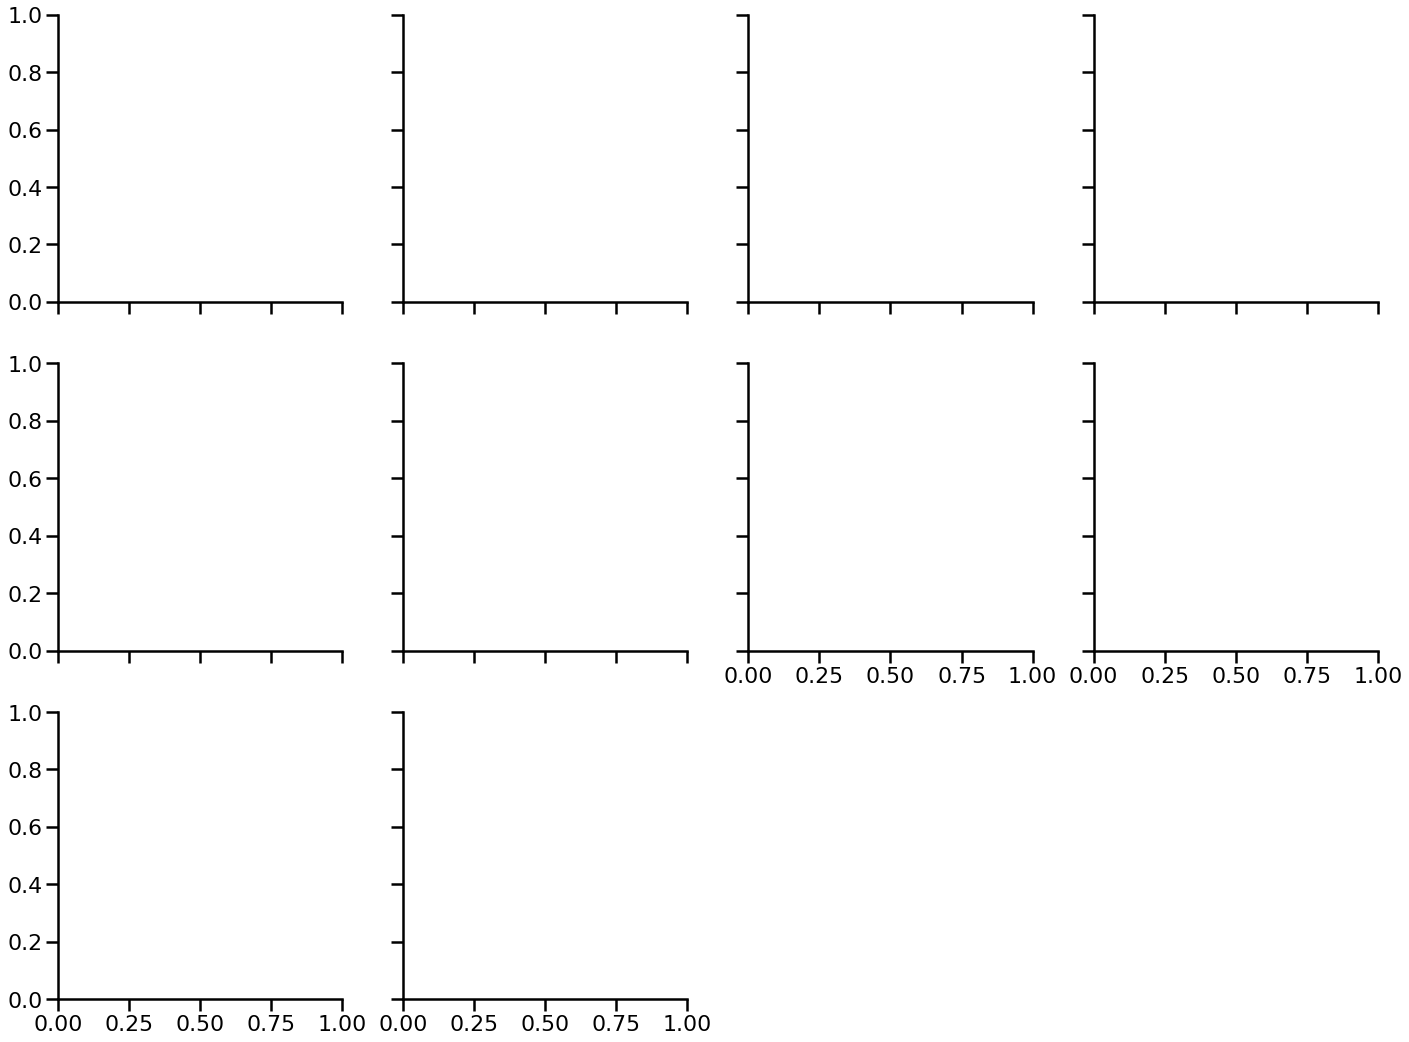

In [22]:
grid = sns.FacetGrid(flag_pct_byclass.reset_index(), col="classification",  palette="tab20c",
                     col_wrap=4, height=5)
grid.map(sns.barplot,y=flag_names)

Formal requirements are on SNR > 6 (note these are *measured* SNRs not detected which is why this looks weird)

In [23]:
diaSources['snr'] = diaSources['apFlux']/diaSources['apFluxErr']

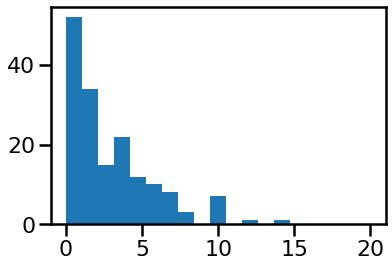

In [24]:
_=plt.hist(diaSources.snr,bins=np.linspace(0,20,20))

In [25]:
wsnrgt6 = diaSources.snr >= 6
np.sum(wsnrgt6)

87

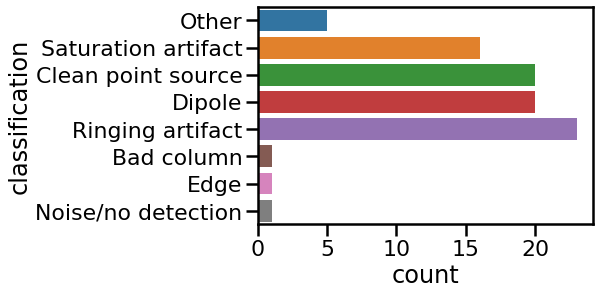

In [26]:
sns.countplot(data=diaSources.loc[wsnrgt6,:],y='classification')

artifact to real ratios:

In [27]:
np.sum(wsnrgt6 & ~(diaSources.classification == 'Clean point source')) / \
np.sum(wsnrgt6 & (diaSources.classification == 'Clean point source'))

3.35

In [28]:
np.sum(~(diaSources.classification == 'Clean point source')) / \
np.sum((diaSources.classification == 'Clean point source'))

4.022988505747127

In [31]:
classifications = diaSources.classification.unique()

array(['Edge', 'Other', 'Saturation artifact', 'Bad column', 'Dipole',
       'Clean point source', 'Ghost', 'Ringing artifact',
       'Noise/no detection', 'Cosmic Ray', None], dtype=object)

In [69]:
for class_name, ids in classgrp[['diaSourceId']].agg(list).iterrows():
    display(HTML(f'<h3>{class_name}</h3>'))
    idl = ids.tolist()[0]
    filenames = [f'./{dataset}_alert_stamp_images/{idi}_diff.png' for idi in idl]
    imagesList=''.join( ["<img style='width: 300px; margin: 0px; float: left; border: 0px solid black;' src='%s' />" % str(s) 
                     for s in sorted(filenames) ])
    display(HTML(imagesList))
    #images = [Image(filename) for filename in filenames]
    #display(*images)
    #for filename in filenames:
    #    display(Image(filename))

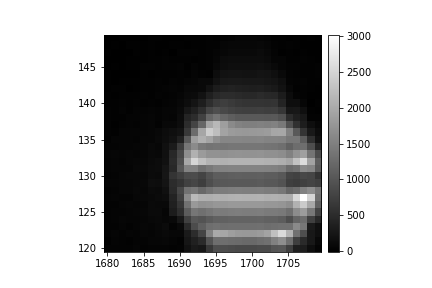

In [63]:
display(Image(filenames[0]))

In [61]:
!ls ./hits_alert_stamp_images/176486846212080145*

./hits_alert_stamp_images/176486846212080145_diff.png
